# Assessing the Likelihood of Contracting Heart Disease Based on 6 Health Factors

## 1. Introduction

### 1.1 Inference Question:
How can be predict if a patient is potential to heart disease based on features such as age, sex, maxbpm....

### 1.2 Background
For nearly a century, heart disease has claimed the many lives of men and women alike, and men are more likely to get it than women(Fallon, 2019). Besides, as the population ages, an increasing number of people are suffering from heart disease (Kodali et al., 2018). Thus, from the above research, we believe that the risk of heart disease is related to gender and age and may also be related to other factors.

### 1.3 The Heart Disease Dataset
The dataset that we will be using for this project is one related to heart disease and the factors that contribute towards it. Different factors such as blood pressure, cholesterol and even age can have great impacts on the risk of contracting heart disease and so this data set provides past details of patients with attributes they had and whether or not they were healthy or not. The link to this dataset is included below, but in this project we will be reading the data directly from the web, and so there is no need to have the file saved locally.

https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/

From the above link, the data from the Cleveland dataset will be used. The original dataset contains 76 factors, however, the processed data, which is what will be used in our project, contains 14 factors. We will further filter this data to be the 6 factors that we will be examining, which are listed below.

#### The Health Factors We Are Focusing On:
- age -> the age of the patient
- sex -> the sex of the patient
- pain.type -> the type of pain experienced by the patient (angina [1], abnormal angina [2], not angina [3], or asymptomatic [4])
- restbps -> the resting blood pressure of the patient
- cholesterol -> the cholesterol level of the patient
- maxbpm -> the maximum heart rate of the patient

We have chosen these specific factors for our analysis, as these are the factors we think would have the greatest influence on whether or not a patient potentially has heart disease. We also think that that heart disease would affect the women more than the men, and thus have included the sex variable, to see if this hypothesis holds true. 

The factors that were omitted, were a boolean value of fasting blood sugar being less than 120, resting ecg, a boolean to determine if the angina was exercise induced, oldpeak, slope, number of vessels coloured, and thalassemia. Some of these predictors were excluded due to their uncertain nature, in terms of measurement units and missing data, such as the number of vessels coloured. One debatable predictor is the resting ecg, which measures the electrical activity in the heart, however we deemed that the resting blood pressure would be a better indicator of heart activity and decided to use that instead.
______________________________________________________________________________________________________________________________________________________

## 2. Wrangling the Data

### 2.1 Loading Tidyverse
First we need to load the tidyverse library into R so that it is possible to wrangle the data and only select the factors that we will be making use of in this project.

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### 2.2 Reading and Selecting the Data
We can make use of the `read_csv` function to extract the data from the web, and since there are no column names in the dataset, we will have to set `col_names = FALSE` and make a vector with the desired column names.

The dataset also classifies sick patients into three different categories, however for this analysis, we will consider all of them as one category, and so we set the `health` column's values 2, 3, and 4, to 1 which signifies contracted-heart-disease, while 0 signifies a healthy patient. This allows us to more easily categorise whether or not the patient contracts a heart disease, regardless of the severity. Finally, we will convert the health column to be a factor variable rather than double, as this will be needed when classifying data.

In [3]:
heart_data<- read_csv(url("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"), col_names = FALSE) |>
    select(X1, X2, X3, X4, X5, X8, X14)
colnames(heart_data) <- make.names(c("age", "sex", "pain.type", "restbps", "cholesterol", "maxbpm", "health"))

heart_data["health"][heart_data["health"] == 2 | heart_data["health"] == 3 | heart_data["health"] == 4] <- 1
heart_data$health <- as_factor(heart_data$health) 

heart_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,pain.type,restbps,cholesterol,maxbpm,health
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,150,0
67,1,4,160,286,108,1
67,1,4,120,229,129,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,115,1
57,0,2,130,236,174,1
38,1,3,138,175,173,0


To more clearly see why we've decided to group all the sick patients together, we have created a table below to show how the data is split, and that if there were 4 different categories of sickness it would create unnecessary confusion and problems.

In [4]:
health_freq <- table(heart_data$health)
rownames(health_freq) = c("Healthy", "Sick")
"# of Patients with and without Heart Disease"
health_freq

[1] "# of Patients with and without Heart Disease"


Healthy    Sick 
    164     139 

In [5]:
summary(heart_data$age)
summary(heart_data$maxbpm)
summary(heart_data$restbps)
summary(heart_data$cholesterol)
summary(heart_data$maxbpm)
table(heart_data$sex)
table(heart_data$pain.type)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  29.00   48.00   56.00   54.44   61.00   77.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   71.0   133.5   153.0   149.6   166.0   202.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   94.0   120.0   130.0   131.7   140.0   200.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  126.0   211.0   241.0   246.7   275.0   564.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   71.0   133.5   153.0   149.6   166.0   202.0 


  0   1 
 97 206 


  1   2   3   4 
 23  50  86 144 

______________________________________________________________________________________________________________________________________________________

## 3. Analysis of Data

### 3.1 Splitting the Dataset into Training and Testing Data
We have chosen to select 75% of the data to be in the training data, while the other 25% will be used as testing data later on. We have also selected a seed to use, so that the results are reproducible in the future.

In [6]:
set.seed(29) # do not change [use this seed throughout]

heart_data_split <- initial_split(heart_data, prop = 0.75, strata = health)
heart_data_training <- training(heart_data_split)
heart_data_testing <- testing(heart_data_split)

### 3.2 Age and Heart Disease
To initially get a grasp on the dataset itself and what we will be conducting an analysis on, we have decided to plot a histogram showing the differing ages, and at what age/age range is a patient most likely to develop a heart disease. This will also provide a good idea of where the majority of the population lies in terms of the age range.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



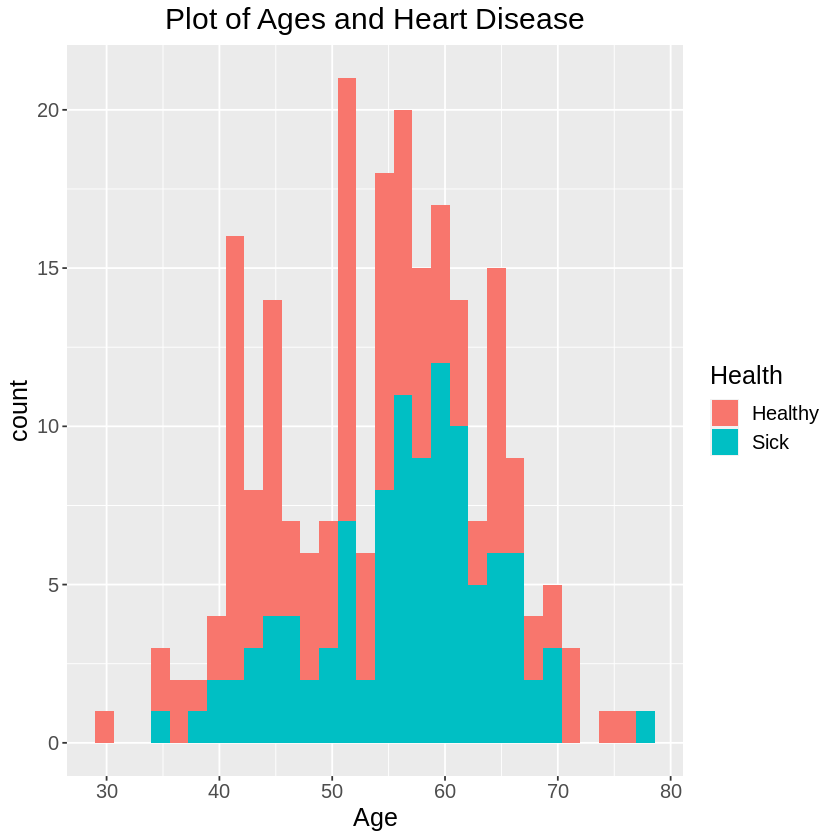

In [7]:
ages_and_heart_disease_plot <- heart_data_training |>
    ggplot(aes(x = age, fill = as_factor(health))) +
    geom_histogram() +
    labs(title = "Plot of Ages and Heart Disease", x = "Age", fill = "Health") +
    scale_fill_discrete(labels = c("Healthy", "Sick")) +
    theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5))
ages_and_heart_disease_plot

This plot provides a good visualisation of the dataset, and it shows with the differently coloured plots, we are able to see that the at-risk age range to contract heart disease seems to be around 60 years old. It is noted that although this age is where the number of sick patients peaks, it is also seent that a larger percentage of the population at this age, is healthy.

### 3.3 Sex and Heart Disease
One other correlation we would like to explore from this dataset is if there is any immediate correlation between the sex of the patient and the likelihood that they contract heart disease. To visualise this we will be making use of a histogram and the `facet_grid` function to be able to split the data, and clearly see the different categories.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



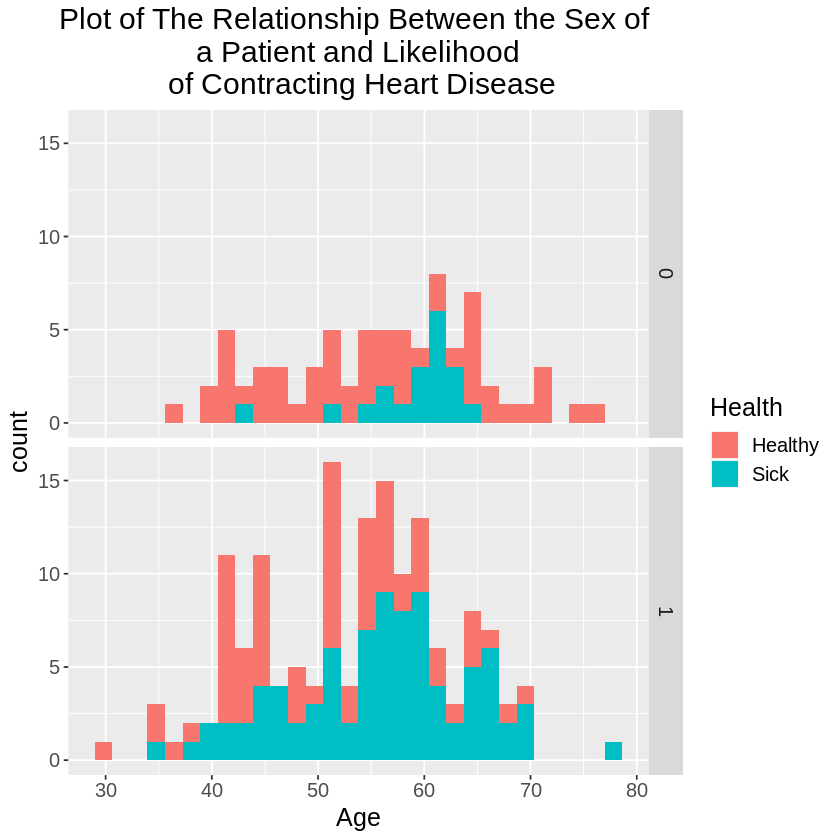

In [18]:
sex_and_heart_disease_plot <- heart_data_training |>
    ggplot(aes(x = age, fill = as_factor(health))) +
    geom_histogram() +
    facet_grid(rows = vars(sex)) +
    labs(title = "Plot of The Relationship Between the Sex of \n a Patient and Likelihood \n of Contracting Heart Disease", x = "Age", fill = "Health") +
    scale_fill_discrete(labels = c("Healthy", "Sick")) +
    theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5))

sex_and_heart_disease_plot

From the plot above we can see that the male population [1], in this dataset is far greater than the female population [0], however it is not too clear what exactly the proportion for each cateogry is in terms of sickness and health. Therefore we can `filter` the data set and see how many rows occur for each category.

In [26]:
male_total <- heart_data_training |>
    filter(sex == 1) |>
    nrow()

male_sick <- heart_data_training |>
    filter(sex == 1) |>
    filter(health == 1) |>
    nrow()

male_ratio <- (male_sick / male_total)

female_total <- heart_data_training |>
    filter(sex == 0) |>
    nrow()

female_sick <- heart_data_training |>
    filter(sex == 0) |>
    filter(health == 1) |>
    nrow()

female_ratio <- (female_sick / female_total)


print('Proportion of males that are sick: ')
print(male_ratio)
print('Proportion of females that are sick: ')
print(female_ratio)

[1] "Proportion of males that are sick: "
[1] 0.5555556
[1] "Proportion of females that are sick: "
[1] 0.2567568


From the data above we can see that in this dataset, approximately 56% of the males have contracted heart disease, while the proportion of female patients that contracted a heart disease was less than half at around 26%. This shows that when conducting the analysis, sex could play a more significant role than what is intended and may need to be omitted.

### 3.4 Chest Pain and Heart Disease
The first correlation we would like to explore is that between chest pain and heart disease. To visualise this, we will make use of a histogram, as well as a facet grid that encompasses the 4 different type of chest pains that were recorded in this dataset, that will essentially split the plot above into 4 different plots. To refresh, these chest pain types are angina [1], abnormal angina [2], not angina [3], or asymptomatic [4]. We will then colour the bars of the historgam to signify which patients were healthy and which contracted a heart disease.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



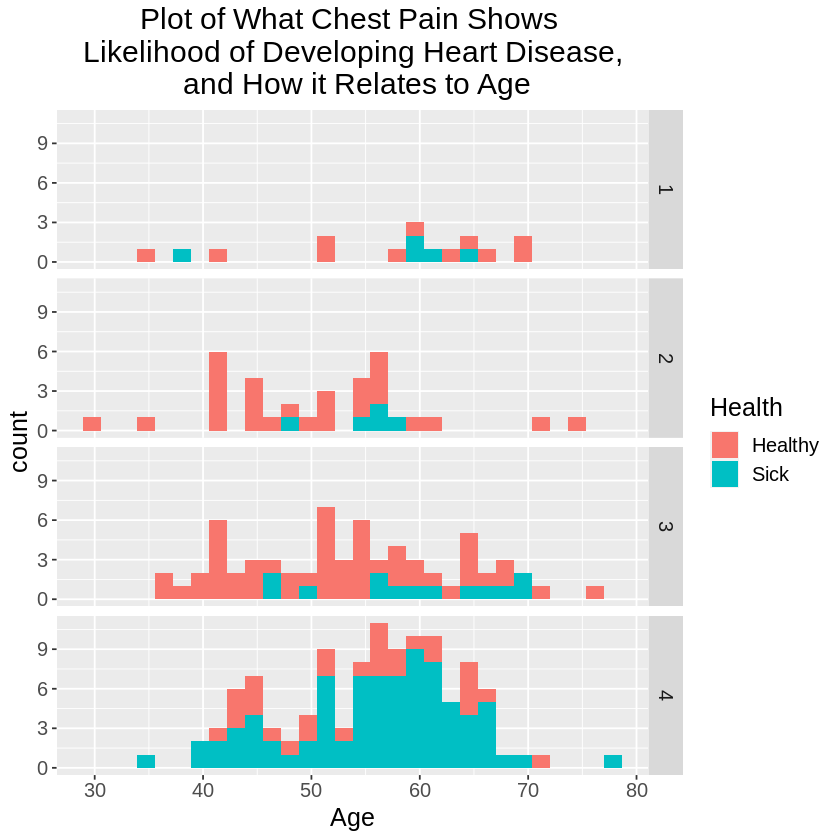

In [9]:
likelihood_of_heart_disease_plot <- heart_data_training |>
    ggplot(aes(x = age, fill = as_factor(health))) +
    geom_histogram() +
    facet_grid(rows = vars(pain.type)) +
    labs(title = "Plot of What Chest Pain Shows \n Likelihood of Developing Heart Disease, \n and How it Relates to Age", x = "Age", fill = "Health") +
    scale_fill_discrete(labels = c("Healthy", "Sick")) +
    theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5))

likelihood_of_heart_disease_plot

From the visualisation above, it is clear to see that the vast majority of patients in general are in category 4, which is asymptomatic. Additionally this is where the largest proportion of the sick population is as well, and it is illustrated that with the other types of chest pain, the ratio of healthy to sick is uneven, with there being more healthy patients than not. From this plot we can hypothesise that although chest pain could potentially be an indicator of contracting a heart disease, it is more likely that it is it's own issue, unrelated to heart disease.

### 3.5 Max Heart Rate and Heart Disease
Next we'd like to see how heart rate changes with age and if there is an clear, visible relationship between that and the likelihood of contratcing a heart disease. To visualise this, we will plot the data on a scatterplot, with age on the x-axis and max heart rate on the y-axis, and just like the previous plots, colour the points based on whether the patients were sick or healthy.

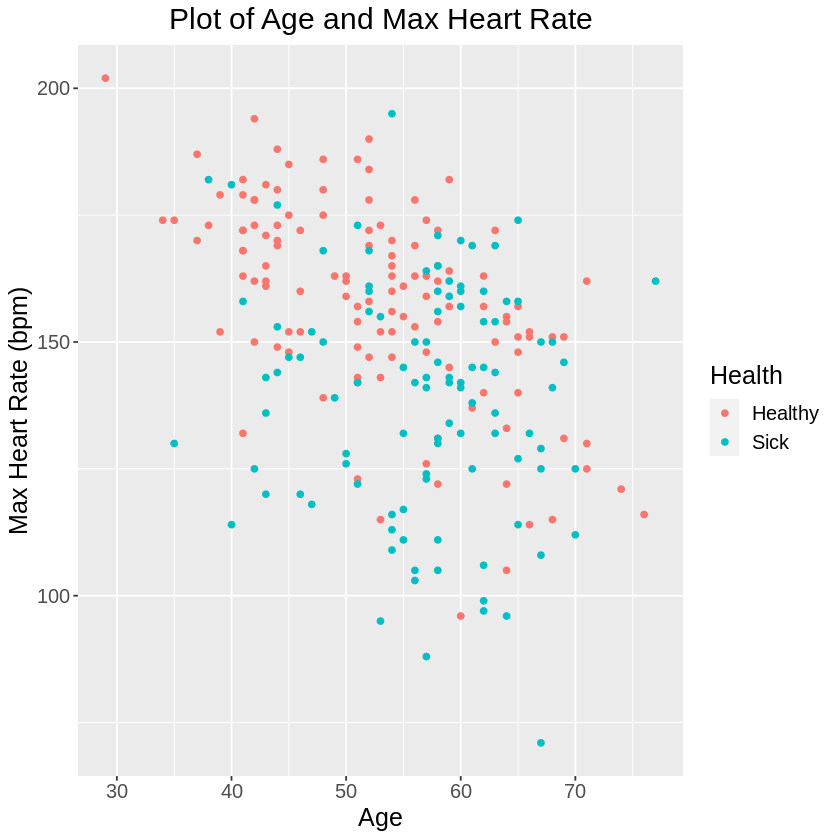

In [10]:
age_and_max_heart_rate_plot <- heart_data_training |>
    ggplot(aes(x = age, y = maxbpm, colour = as_factor(health))) +
    geom_point() +
    labs(title = "Plot of Age and Max Heart Rate", x = "Age", y = "Max Heart Rate (bpm)", colour = "Health") +
    scale_colour_discrete(labels = c("Healthy", "Sick")) +
    theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5))
age_and_max_heart_rate_plot

From the diagram above, the expected downward trend of the points is seen, as with increasing age, the peak heart rate will decrease. However we can also see that the bulk of the healthy patients are ones with a higher max heart rate, while the sick patients seem to have a lower average max heart rate. This suggests a correlation between this variable and the likelihood to develop heart disease.

### 3.6 Cholesterol and Heart Disease
Finally the last relationship we want to see visualised before conducting the rest of our analysis, is one between cholesterol levels in the patient and them contracting heart disease. This plot will also be in the form of a scatter plot, with age once again on the x-axis and cholesterol on the y-axis.

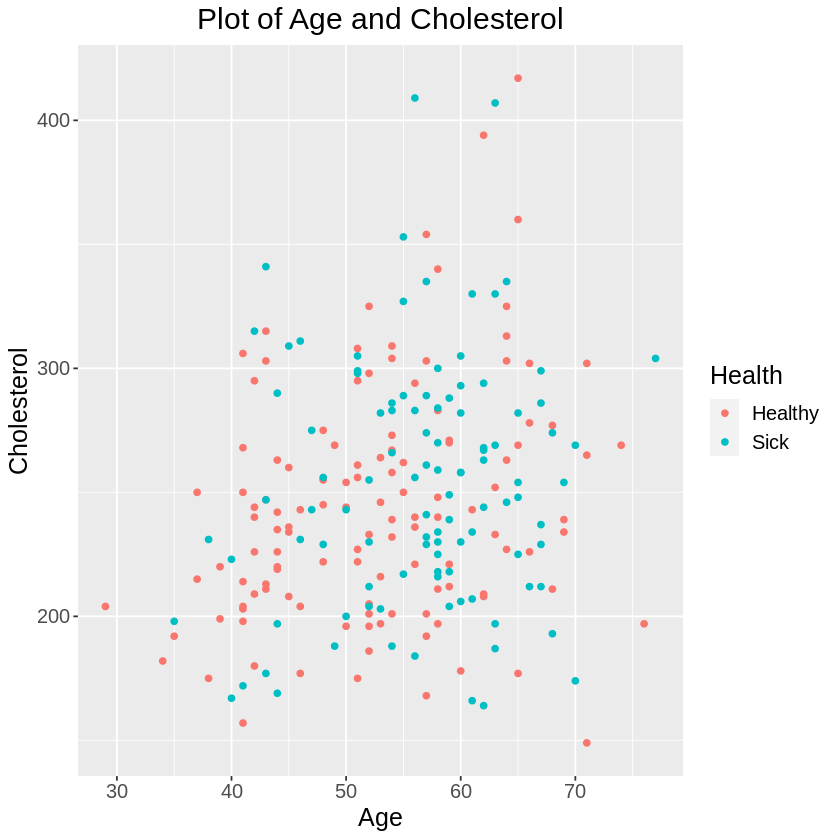

In [11]:
age_and_cholesterol_plot <- heart_data_training |>
    ggplot(aes(x = age, y = cholesterol, colour = as_factor(health))) +
    geom_point() +
    labs(title = "Plot of Age and Cholesterol", x = "Age", y = "Cholesterol", colour = "Health") +
    scale_colour_discrete(labels = c("Healthy", "Sick")) +
    theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5))
age_and_cholesterol_plot

From this plot, there is a very slight upward trend in the cholesterol levels in the patient, and this shows that as the age of the patients increases, it is typical for the cholesterol levels to increase slightly too, with some outliers. However, there seems to be little to no correlation between the cholesterol and the patient contracting heart disease, with the majority of the sick patients having slightly higher cholesterol levels. Although, as mentioned before this could also be in relation to the increasing age.
______________________________________________________________________________________________________________________________________________________

## 4. KNN Classification

### 4.1 Creating the Recipe and Conducting Cross Validation
The first step in KNN classification is to create the recipe that will be used in the algorithm and model that we build to classify the testing data. This recipe determines which variables are the predictors, and which is the variable being predicted. In this step, the predictor variables are also stepped and centered, so that the Euclidean distance between the points is just what is seen on the visualisation itself, and the varying units of measurement of the different values, don’t interfere with the predictions later in the analysis.

In [12]:
heart_recipe <- recipe(health ~ ., data = heart_data_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
heart_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          6

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Next we will conduct cross validation, through use of the `vfold` function, and we have decided to use 5 folds. We have come upon this number because with the number of points in this data set, 303, only 75% of it, 227, are being used as the training data. Therefore we have concluded that 5 even splits of the data, will allow enough data to be in each split, to act as the validating data when conducting this section of the analysis. Any higher would be too little data in each section, and any lower could result in less valid data.

In [13]:
set.seed(29) # do not change [use this seed throughout]

heart_vfold <- vfold_cv(heart_data_training, v = 5, strata = health)

### 4.2 Tuning the Model
To begin the KNN analysis on the recipe we have just created, we will first create an algorithm that makes use of the `tune()` function for the number of neighbours, so that we can find the optimal $k$-value to use later on, to classify our testing data correctly. We will set the engine to `“kknn”` and set the mode to `“classification”`. 

With this we can then create a workflow, to tune the grid using the cross-validation from before, and then collect the metric of accuracy. We are also making use of the `tune_grid()` function so that the model will fit each value in a range of parameter values. The `collect_metrics()` function is the important part of this step and will be used next to visualise the accuracy of the different $k$-values that were tested.

In [14]:
set.seed(29) # do not change [use this seed throughout]

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
knn_tune

knn_results <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = heart_vfold, grid = 10) |>
    collect_metrics()
knn_results

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.7137637,5,0.01103231,Preprocessor1_Model01
2,roc_auc,binary,0.8062421,5,0.01692994,Preprocessor1_Model01
3,accuracy,binary,0.7922134,5,0.02642830,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,roc_auc,binary,0.8542381,5,0.02131679,Preprocessor1_Model09
15,accuracy,binary,0.7834212,5,0.02703750,Preprocessor1_Model10
15,roc_auc,binary,0.8575179,5,0.02087878,Preprocessor1_Model10


### 4.3 Selecting the Optimal $k$-value
With the metrics that were collected, we can now filter, the data frame to only focus on those where the `.metric` column concerns the `"accuracy"` of the data, and then product a scatter and line plot of the data. This will create what is known as an elbow graph, which will show where the accuracy peaks, which allows us to select the best $k$-value for our classification model.

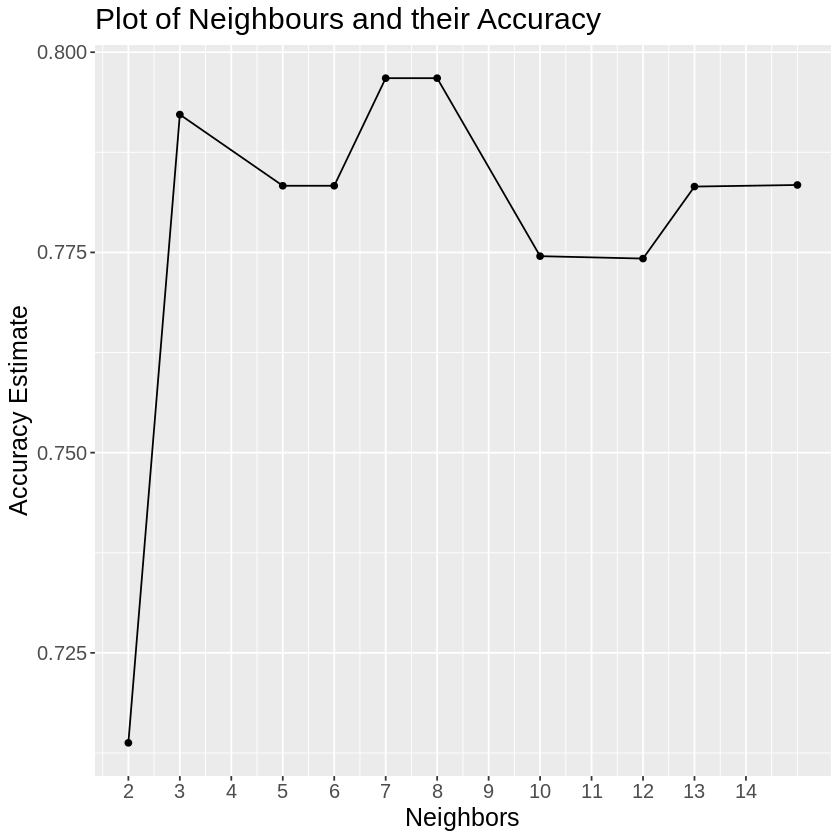

In [15]:
accuracies <- knn_results |>
    filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    ggtitle("Plot of Neighbours and their Accuracy") +
    scale_x_continuous(breaks = seq(2, 14, by = 1)) +
    theme(text = element_text(size = 15))
accuracy_versus_k

From the graph above, there is a very distinct peak, which occurs when there are 7 or 8 neighbours, which informs us that for the model we will build now, we must make use of `k = 7` or `k = 8` neighbours in order to get the algorithm to be as good as it can be.

### 4.4 Building the KNN Model
Now that we have obtained the optimal $k$-values, we will create a new model named `knn_tuned_spec` that makes use of 7 neighbours. We can still use the recipe that we created before as this won't be affected by any previous calculations. Then we can create the workflow that we will name `heart_tuned_fit`, which uses the `knn_tuned_spec` model.

In [16]:
set.seed(29) # do not change [use this seed throughout]

knn_tuned_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_tuned_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_tuned_spec) |>
    fit(data = heart_data_training)
heart_tuned_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(7,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2290749
Best kernel: rectangular
Best k: 7

### 4.5 Testing the Model and Calculating the Accuracy
Finally, we are able to test the model that we have created with the testing data that we split in the initial stages of this analysis. First we need to create a variable called `heart_predictions` that creates a data data frame with the predicted values of `health`, from the testing set, and then bind this data frame to the testing data columns, so that we can compare the `.pred_class` and `health` values.

This is done by making use of the `metrics()` function, which takes in the true values, and compares it to the estimates, which is the predicted values and produces an accuracy statistic. Lastly, we can also create a confusion matrix, `conf_mat()`, which shows how many of each "health type", sick or healthy, the model predicted correctly.

In [17]:
heart_predictions <- predict(heart_tuned_fit, heart_data_testing) |>
    bind_cols(heart_data_testing)

heart_metrics <- heart_predictions |>
    metrics(truth = health, estimate = .pred_class)

heart_conf_mat <- heart_predictions |>
    conf_mat(truth = health, estimate = .pred_class)

heart_predictions
heart_metrics
heart_conf_mat

.pred_class,age,sex,pain.type,restbps,cholesterol,maxbpm,health
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,63,1,4,130,254,147,1
0,52,1,3,172,199,162,0
0,49,1,2,130,266,171,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,45,1,1,110,264,132,1
1,57,1,4,130,131,115,1
0,57,0,2,130,236,174,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8026316
kap,binary,0.6002805


          Truth
Prediction  0  1
         0 35  9
         1  6 26

From the tables and data frames above, it can be seen that the model was not entirely accurate, however it was not inaccurate either. Looking at the metrics, it can be seen that the model has a 80.2% accuracy. It is not very inaccurate, but nonetheless is not an entirely reliable model to form very accurate predictions of whether a new patient's data points towards them being likely to contract heart disease or not.
______________________________________________________________________________________________________________________________________________________

## 5. Discussion

Based on the above analysis, we found that six different factors were used to determine whether a person would have a heart disease  with 80.2%. In our exception, we think the accuracy we get from these data is high and higher the accuracy of the model, the better the model which can predict more potential heart disease help with treatment. The impact of the analysis would help people a lot in preventing heart disease in an early stage. It can potentially prevent heart disease from developing entirely if they find, for instance, their resting blood pressure to be in a sort of "danger" zone in terms of contracting heart disease. 

For the future question, if we can do a good job of predicting patients through these six factors, we hope to able to predict what type of disease patients are going to get.

## 6. References

Fallon, C. K. (2019). Husbands' hearts and women's health: Gender, age, and heart disease in twentiethcentury america. *Bulletin of the          History of Medicine, 93*(4), 577-609. https://doi.org/10.1353/bhm.2019.0073

Kodali, S. K., Velagapudi, P., Hahn, R. T., Abbott, D., & Leon, M. B. (2018). Valvular heart disease in Patients ≥80 Years of age. *Journal of the American College of Cardiology, 71*(18), 2058-2072. https://doi.org/10.1016/j.jacc.2018.03.459

Pruthi, S. (2023, January 11). *High cholesterol*. Mayo Clinic. Retrieved April 11, 2023, from https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/symptoms-causes/syc-20350800.